 #### Finetuning the convnet: 
    Instead of random initializaion, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.

#### ConvNet as fixed feature extractor: 
    Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.


## Deely Understand about Traing, Validation , Test Phase

### Training Phase :
- Similar to the a lecture being taught in college. Concepts discussed in class and reasoning discussed by the professor to give you an idea about the problem domain. This usually comprises about 65% of the time you spend in college.

### Validation Phase :
- This is the tutorials you attend with the Teaching Assistant. You have learnt some concepts with the professor is training you during lecture hours. Here the TA usually gives you an assignment you are expected to solve and then discusses the solutions so that you can formalise your understanding of the concepts before you go to the final exam ( Testing Phase). This like tutorials would comprise about 20% of the total time.

### Testing Phase :
- This is the final exam. This objective here is to assess the concepts you learnt initially in the lectures(Training) and built upon in the tutorials(Validation). Here, ideally you are not provided with the answers beforehand :p. You submit your answers and an analysis of your performance is provided by various metrics. The testing phases tests the generalisation capabilities of the model(student in this case) beyond the training set.( Questions covered in lectures and tutorials).


![title](imageTutorial/vgg16Arch.png)

In [24]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os 
import copy
from PIL import Image

#interactive mode
plt.ion() 

# Load Data

#### Train a model to classify ants and bees.

    - Training Images: 120 Imgs/class
    - Validation Images: 75 Imgs/class

In [2]:
# Data augmentation and normalization for training
# Just normalization for validtion
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]), 
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data\hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualize a few images

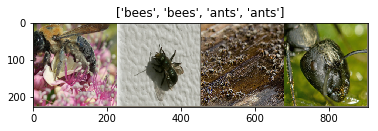

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Training the model
- Scheduling the learning rate
- Saving the best model

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs= 25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                #Set model to training mode
                model.train() 
            else:
                #Set model to evaluate mode
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            #Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                #Zero the params gradients
                optimizer.zero_grad()
                
                ### Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    #backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss,epoch_acc))
            
            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    
    #Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Visualizing the model predictions
This is generic function to display predictions for a few images

In [5]:
def visualize_model(model, num_images= 6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fipreg = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                # plt.subplot(行数, 列数, 何番目のプロットか)
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode= was_training)
                    return
        model.train(model=was_training)

# Finetuning the convnet
- Load a pretrained model and reset final fully connected layer

Here pretrained model is using AlexNet

In [11]:
model_ft = models.vgg16(pretrained=True)
model_ft.fc = nn.Linear(4096, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all params are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr= 0.001, momentum= 0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train And Evaluate

In [7]:
model_ft = train_model(model_ft, criterion, 
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 2.3991 Acc: 0.5164
val Loss: 1.0108 Acc: 0.5098

Epoch 1/24
----------
train Loss: 1.0818 Acc: 0.5328
val Loss: 0.7526 Acc: 0.5425

Epoch 2/24
----------
train Loss: 0.8574 Acc: 0.4959
val Loss: 0.7005 Acc: 0.5163

Epoch 3/24
----------
train Loss: 0.7833 Acc: 0.5697
val Loss: 0.8358 Acc: 0.6275

Epoch 4/24
----------
train Loss: 0.7179 Acc: 0.6557
val Loss: 0.7525 Acc: 0.5817

Epoch 5/24
----------
train Loss: 0.6345 Acc: 0.6885
val Loss: 0.5679 Acc: 0.7451

Epoch 6/24
----------
train Loss: 0.5814 Acc: 0.7090
val Loss: 0.4799 Acc: 0.7974

Epoch 7/24
----------
train Loss: 0.4979 Acc: 0.7705
val Loss: 0.4730 Acc: 0.7908

Epoch 8/24
----------
train Loss: 0.5153 Acc: 0.7582
val Loss: 0.4704 Acc: 0.8039

Epoch 9/24
----------
train Loss: 0.4785 Acc: 0.7869
val Loss: 0.4525 Acc: 0.8105

Epoch 10/24
----------
train Loss: 0.4379 Acc: 0.8197
val Loss: 0.5619 Acc: 0.7386

Epoch 11/24
----------
train Loss: 0.4429 Acc: 0.7992
val Loss: 0.4352 Acc: 0.8431

Ep

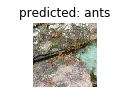

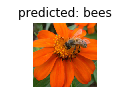

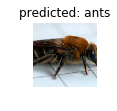

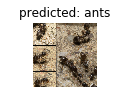

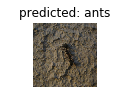

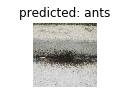

In [8]:
#Visualize model 
visualize_model(model_ft)


# ConvNet as fixed feature extractor

Freeze all the network except the final layer. Set 'requires_grad == False' to freeze the parameters so that the gradients are not computed in backward().

In [14]:
model_conv = models.vgg16(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
# parameters of newly constructed modules have requires_grad = True by default
model_conv.fc = nn.Linear(4096, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr= 0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [15]:
model_conv = train_model(model_ft, criterion, 
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 2.1687 Acc: 0.4959
val Loss: 0.7378 Acc: 0.5556

Epoch 1/24
----------
train Loss: 1.0372 Acc: 0.4959
val Loss: 0.6257 Acc: 0.6928

Epoch 2/24
----------
train Loss: 0.8152 Acc: 0.5451
val Loss: 0.8227 Acc: 0.5621

Epoch 3/24
----------
train Loss: 0.8800 Acc: 0.5943
val Loss: 0.7906 Acc: 0.4706

Epoch 4/24
----------
train Loss: 0.6443 Acc: 0.6762
val Loss: 0.4961 Acc: 0.7712

Epoch 5/24
----------
train Loss: 0.6684 Acc: 0.6926
val Loss: 0.5959 Acc: 0.6797

Epoch 6/24
----------
train Loss: 0.6010 Acc: 0.7172
val Loss: 0.7661 Acc: 0.6340

Epoch 7/24
----------
train Loss: 0.4854 Acc: 0.8156
val Loss: 0.4836 Acc: 0.8170

Epoch 8/24
----------
train Loss: 0.4486 Acc: 0.8115
val Loss: 0.4853 Acc: 0.8039

Epoch 9/24
----------
train Loss: 0.5564 Acc: 0.7500
val Loss: 0.4666 Acc: 0.7843

Epoch 10/24
----------
train Loss: 0.3589 Acc: 0.8484
val Loss: 0.4326 Acc: 0.8105

Epoch 11/24
----------
train Loss: 0.4959 Acc: 0.7869
val Loss: 0.3689 Acc: 0.8562

Ep

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [12]:
print(model_conv)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [13]:
model_ft.fc

Linear(in_features=4096, out_features=2, bias=True)

# Predict

Prediction in progress


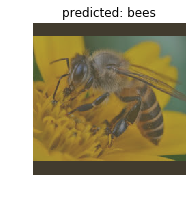

In [26]:
def predict_image(image_path):
    print("Prediction in progress")
    image = Image.open(image_path)

    # Define transformations for the image, should (note that imagenet models are trained with image size 224)
    transformation = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

    ])

    # Preprocess the image
    image_tensor = transformation(image).float()

    # Add an extra batch dimension since pytorch treats all images as batches
    image_tensor = image_tensor.unsqueeze_(0)

    if torch.cuda.is_available():
        input = Variable(image_tensor.cuda())

    # Turn the input into a Variable
    #input = Variable(image_tensor)
    #input = input.to(device)

    
    # Predict the class of the image
    output = model_conv(input)
    
    _, preds = torch.max(output, 1)
            
    ax = plt.subplot(121)
    ax.axis('off')
    ax.set_title('predicted: {}'.format(class_names[preds]))
    imshow(input.cpu().data[0])

#Save Model
#PATH1 = 'data/antbeeResNetModel.pt'
#PATH2 = 'data/antbeeResNetModel.pth.tar'

#torch.save(model_conv, PATH2)
#model = torch.load(PATH2)

image_path = 'data\\hymenoptera_data\\test\\download.jfif'
predict_image(image_path)